In [1]:
pip install siuba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 207 kB 5.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from siuba.dply.forcats import fct_lump

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/CS334_FP/

/content/drive/.shortcut-targets-by-id/1dRC0udwQXHaykf4WdWROQASLREaiNsOY/CS334_FP


#Preprocessing

In [ ]:
X = pd.read_csv('training_set_values.csv').fillna(np.nan)
y = pd.read_csv('training_set_labels.csv')

In [ ]:
df = X.merge(y, on = 'id')

In [ ]:
def encoding(element):
  if element == 'functional':
    return 0
  elif element == 'non functional':
    return 2
  elif element == 'functional needs repair':
    return 1
  else:
    return None

df['label_encoded']= np.c_[list(map(encoding, df['status_group']))]
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,label_encoded
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0


In [ ]:
y['status_group'].value_counts()

# functional prop = 32259 / 59400 = 0.543
# non functional prop = 22824 / 59400 = 0.384
# functional needs repair = 4317 / 59400 = 0.073

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

Text(0.5, 1.0, 'Class Frequency')

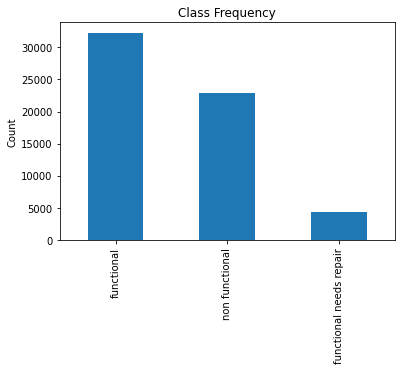

In [ ]:
# Plot of imbalanced data (for use in presentation/paper)
y['status_group'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Class Frequency')

Check missing variables

In [ ]:
# Examine missing variables
df.isna().sum().sort_values(ascending = False)

# scheme_name: who operates the waterpoint
# construction year: what year the waterpoint was constructed
# scheme management: who operates the waterpoint (but different than scheme_name)
# installer: who installed the waterpoint
# funder: who funded the well
# public meeting: only encoded as T/F, no variable description
# permit: if the waterpoint is permitted
# subvillage: geographic location

# Since scheme_management encodes similar information as scheme_name, but has many less missing values, we will drop scheme_name


scheme_name              28166
scheme_management         3877
installer                 3655
funder                    3635
public_meeting            3334
permit                    3056
subvillage                 371
water_quality                0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
quantity                     0
quality_group                0
extraction_type              0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
status_group                 0
extraction_type_group        0
id                           0
construction_year            0
basin                        0
date_recorded                0
gps_height                   0
longitude                    0
latitude                     0
wpt_name                     0
num_priv

In [ ]:
df.nunique() # 'recorded_by' only has one unique value -  we can drop this

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [ ]:
df = df.drop(columns = ['scheme_name', 'recorded_by'], axis = 1)

Continuous Variable Cleaning

In [ ]:
# Encode binary variables permit and public_meeting as 0/1
df.permit = df.permit.replace({True: 1, False: 0})
df.public_meeting = df.public_meeting.replace({True: 1, False: 0})

In [ ]:
# Can't use datetime variable types in models, so we extract year and month features

df['year_recorded'] = pd.DatetimeIndex(df['date_recorded']).year
df['month_recorded'] = pd.DatetimeIndex(df['date_recorded']).month
df = df.drop(['date_recorded'], axis = 1)

In [ ]:
# Examine continuous variables
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,permit,construction_year,label_encoded,year_recorded,month_recorded
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,56066.000000,56344.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,0.909838,0.689550,1300.652475,0.841162,2011.921667,4.375640
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,0.286416,0.462682,951.620547,0.949794,0.958758,3.029247
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2002.000000,1.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2011.000000,2.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1.000000,1.000000,1986.000000,0.000000,2012.000000,3.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,1.000000,1.000000,2004.000000,2.000000,2013.000000,7.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,1.000000,1.000000,2013.000000,2.000000,2013.000000,12.000000


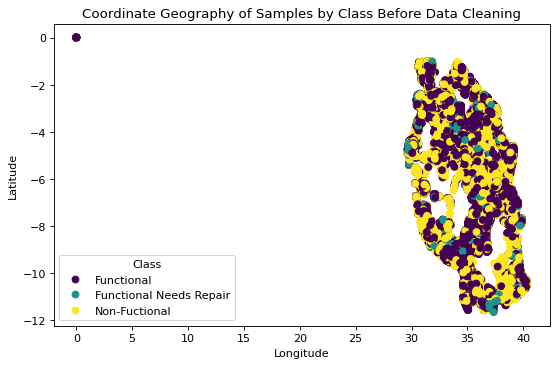

In [ ]:
figure(figsize=(8, 5), dpi=80)
a = plt.scatter(x = df['longitude'], y = df['latitude'], c = df['label_encoded'])
class_names = ['Functional', 'Functional Needs Repair', 'Non-Fuctional']
plt.title('Coordinate Geography of Samples by Class Before Data Cleaning')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=a.legend_elements()[0], 
           labels=class_names,
           title="Class")
#plt.legend(loc="lower left")
# outlier point glob should be NaN

1812


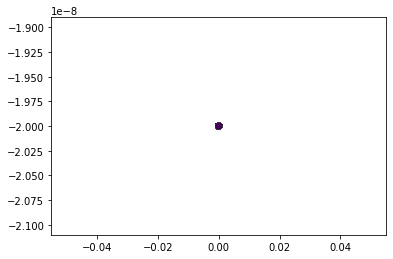

In [ ]:
test = df[df['longitude'] == 0]
print(len(test)) # 1812 rows have longitude == 0 and latitude == -2.000000e-08. Tanzania has longitude between 29-40 so these are erroneous.
plt.scatter(x = test['longitude'], y = test['latitude'], c = test['label_encoded'])

Text(0.5, 1.0, 'Distribution of Construction Year Variable Before Data Cleaning')

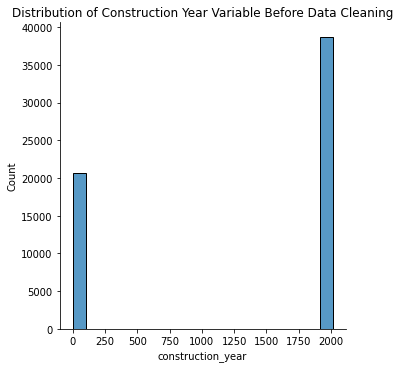

In [ ]:
sns.displot(df, x="construction_year")
plt.title('Distribution of Construction Year Variable Before Data Cleaning')


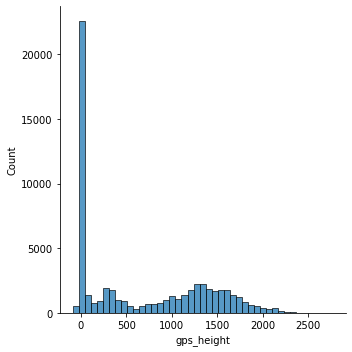

In [ ]:
sns.displot(df, x = 'gps_height')

Text(0, 0.5, 'Count')

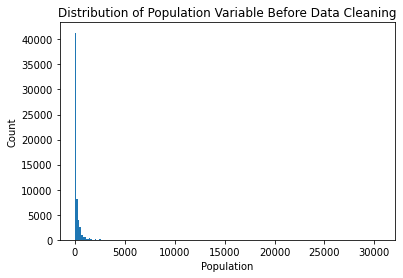

In [ ]:
#sns.displot(df, x = 'population')
plt.hist(df['population'], bins = 200)
plt.title('Distribution of Population Variable Before Data Cleaning')
plt.xlabel('Population')
plt.ylabel('Count')

In [ ]:
test = df[df['population'] == 0] 
len(test) # 21381 observations have population == 0

21381

In [ ]:
# Continuous variable cleaning

 # amount_tsh: total static head (amount water available to waterpoint) 
    # if functional/functional needs repair + amount_tsh = 0 --> change to nan (erroneous)
    # if needs repair + amount_tsh = 0 --> leave?

df['amount_tsh'] = np.where((df['amount_tsh'] == 0) & (df['status_group'] == 'functional'), np.nan, df['amount_tsh'])
df['amount_tsh'] = np.where((df['amount_tsh'] == 0) & (df['status_group'] == 'functional needs repair'), np.nan, df['amount_tsh'])

 # gps_height: altitude of the well (negative values are fine)

 # long/lat - erroneous values found using scatterplot

df['latitude'] = np.where(df['longitude'] == 0, np.nan, df['latitude'])
df['longitude'] = np.where(df['longitude'] == 0, np.nan, df['longitude'])

 # num_private: no description and most values are 0 --> drop

df = df.drop(columns = ['num_private'], axis = 1)

 # region_code: geographic location (coded) --> treat as categorical + nonordinal
 # district code: geographic location (coded) --> treat as categorical + nonordinal
    # will likely remove one later because of multicollinearity

 # population: population around the well --> replace 0s with nan
df['population'] = np.where(df['population'] == 0, np.nan, df['population'])

 # construction_year: year the waterpoint was constructed
    # change year = 0 to nan

to_replace = {'construction_year': {0: np.nan}}
df = df.replace(to_replace)

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.8/dist-packages/matplotlib/ticker.py:586: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


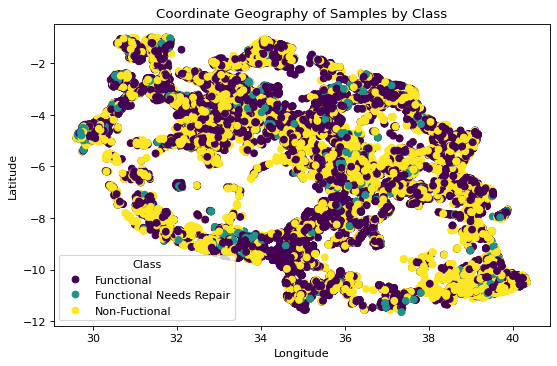

In [ ]:
figure(figsize=(8, 5), dpi=80)
a = plt.scatter(x = df['longitude'], y = df['latitude'], c = df['label_encoded'])
class_names = ['Functional', 'Functional Needs Repair', 'Non-Fuctional']
plt.title('Coordinate Geography of Samples by Class')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=a.legend_elements()[0], 
           labels=class_names,
           title="Class")

Text(0.5, 1.0, 'Distribution of Construction Year Variable After Data Cleaning')

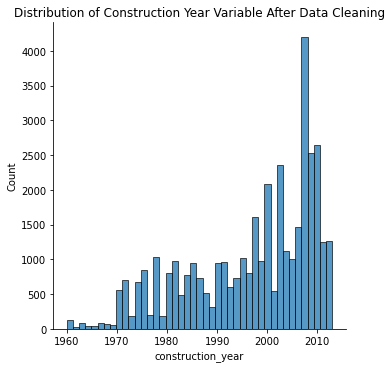

In [ ]:
sns.displot(df, x="construction_year")
plt.title('Distribution of Construction Year Variable After Data Cleaning')


Text(0, 0.5, 'Count')

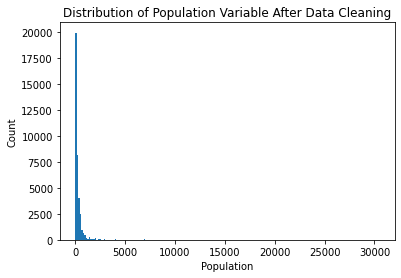

In [ ]:
plt.hist(df['population'], bins = 200)
plt.title('Distribution of Population Variable After Data Cleaning')
plt.xlabel('Population')
plt.ylabel('Count')

Text(0.5, 1.0, 'Pearson Correlation Heatmap Matrix of Continuous Data Before Imputation')

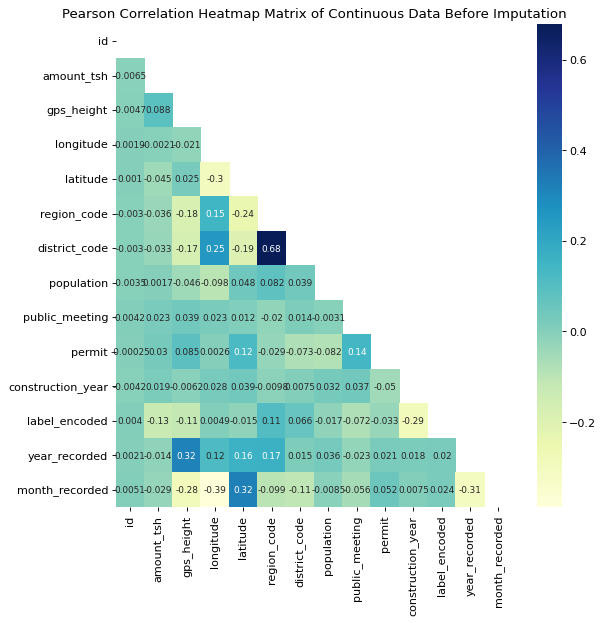

In [ ]:
figure(figsize=(8, 8), dpi=80)
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, annot_kws={"size":8}, mask = np.triu(df.corr()))
plt.title('Pearson Correlation Heatmap Matrix of Continuous Data Before Imputation')
# correlation between district code and region code: this makes sense because district is part of region
# correlation between district code, region code, and long/lat: all geographic features

# TODO for linear models: drop district code because it is highly correlated with region code and longitude, but region code is more correlated with target variable y_encoded
# TODO for linear models: potentially drop year/month recorded? they are correlated with lots of other vars

In [ ]:
df.groupby(by = 'status_group').mean()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,construction_year,label_encoded,year_recorded,month_recorded
status_group,,,,,,,,,,,,,,
functional,37036.753154,1186.740162,740.131188,35.191149,-5.863043,13.616417,5.134660,288.314606,0.928943,0.704276,1999.938675,0.0,2011.894355,4.335410
functional needs repair,37151.263609,908.548463,627.607135,34.309867,-5.669513,15.443595,4.759092,297.370574,0.893776,0.671397,1995.257911,1.0,2012.074589,4.023628
non functional,37219.076498,123.481230,574.464774,35.239450,-5.955471,17.644585,6.494173,267.765319,0.885575,0.672186,1992.397538,2.0,2011.931344,4.499080


Collapsing categorical variables

In [ ]:
# Number of unique values in each column
df.nunique().sort_values(ascending = False)

id                       59400
latitude                 57516
longitude                57515
wpt_name                 37400
subvillage               19287
gps_height                2428
installer                 2145
ward                      2092
funder                    1897
population                1048
lga                        125
amount_tsh                  98
construction_year           54
region_code                 27
region                      21
district_code               20
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
month_recorded              12
source                      10
basin                        9
water_quality                8
extraction_type_class        7
waterpoint_type              7
payment                      7
payment_type                 7
source_type                  7
waterpoint_type_group        6
quality_group                6
quantity                     5
manageme

In [ ]:
df['wpt_name_top20'] = fct_lump(df['wpt_name'], n = 20) # collapse to top 20 levels
df['wpt_name_top20'].value_counts() # check your levels

Other              50104
none                3563
Shuleni             1748
Zahanati             830
Msikitini            535
Kanisani             323
Bombani              271
Sokoni               260
Ofisini              254
School               208
Shule Ya Msingi      199
Shule                152
Sekondari            146
Muungano             133
Mkombozi             111
Madukani             104
Hospital              94
Mbugani               94
Upendo                93
Kituo Cha Afya        90
Mkuyuni               88
Name: wpt_name_top20, dtype: int64

In [ ]:
df['subvillage_top20'] = fct_lump(df['subvillage'], n = 20) # collapse to top 20 levels
df['subvillage_top20'].value_counts() # check your levels

Other         54765
Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
Sokoni          232
M               187
Muungano        172
Mbuyuni         164
Mlimani         152
Songambele      147
Msikitini       134
Miembeni        134
1               132
Kibaoni         114
Kanisani        111
I               109
Mapinduzi       109
Mjini           108
Mjimwema        108
Name: subvillage_top20, dtype: int64

In [ ]:
df['installer_top80'] = fct_lump(df['installer'], n = 80) # collapse to top 80 levels
df['installer_top80'].value_counts() # check your levels

DWE                   17402
Other                 13950
Government             1825
RWE                    1206
Commu                  1060
                      ...  
TWE                     111
Central Government      110
MUWSA                   107
DED                     105
FINI WATER              103
Name: installer_top80, Length: 81, dtype: int64

In [ ]:
df['ward_top50'] = fct_lump(df['ward'], n = 50) # collapse to top 50 levels
df['ward_top50'].value_counts() # check your levels

Other               52093
Igosi                 307
Imalinyi              252
Siha Kati             232
Mdandu                231
Nduruma               217
Kitunda               203
Mishamo               203
Msindo                201
Chalinze              196
Maji ya Chai          190
Usuka                 187
Ngarenanyuki          172
Chanika               171
Vikindu               162
Mtwango               153
Matola                145
Zinga/Ikerege         141
Wanging'ombe          139
Maramba               139
Itete                 137
Magomeni              135
Kikatiti              134
Ifakara               134
Olkokola              133
Maposeni              130
Mvomero               129
Igongolo              129
Mlangali              125
Nkoma                 122
Mahongole             121
Nkungulu              121
Rujewa                120
Simbo                 118
Masama Magharibi      116
Mamire                115
Kiranyi               115
Lupalilo              114
Kidatu      

In [ ]:
df['funder_top90'] = fct_lump(df['funder'], n = 90) # collapse to top 90 levels
df['funder_top90'].value_counts() # check your levels

Other                            12480
Government Of Tanzania            9084
Danida                            3114
Hesawa                            2202
Rwssp                             1374
                                 ...  
Villagers                          106
Village Council                    105
Ru                                 105
Halmashauri Ya Wilaya Sikonge      102
Germany                            101
Name: funder_top90, Length: 91, dtype: int64

In [ ]:
df = df.drop(columns = ['wpt_name', 'subvillage', 'installer', 'ward', 'funder'])
df.nunique().sort_values(ascending = False)

id                       59400
latitude                 57516
longitude                57515
gps_height                2428
population                1048
lga                        125
amount_tsh                  98
funder_top90                91
installer_top80             81
construction_year           54
ward_top50                  51
region_code                 27
subvillage_top20            21
wpt_name_top20              21
region                      21
district_code               20
extraction_type             18
extraction_type_group       13
management                  12
month_recorded              12
scheme_management           12
source                      10
basin                        9
water_quality                8
waterpoint_type              7
source_type                  7
payment                      7
payment_type                 7
extraction_type_class        7
quality_group                6
waterpoint_type_group        6
quantity_group               5
year_rec

Dealing with missing values and splitting into training/testing sets

In [ ]:
df.isna().sum().sort_values(ascending = False)

amount_tsh               22754
population               21381
construction_year        20709
scheme_management         3877
installer_top80           3655
funder_top90              3635
public_meeting            3334
permit                    3056
latitude                  1812
longitude                 1812
subvillage_top20           371
waterpoint_type_group        0
source                       0
source_type                  0
ward_top50                   0
source_class                 0
waterpoint_type              0
label_encoded                0
status_group                 0
wpt_name_top20               0
quantity                     0
year_recorded                0
month_recorded               0
quantity_group               0
id                           0
quality_group                0
water_quality                0
payment_type                 0
management_group             0
management                   0
extraction_type_class        0
extraction_type_group        0
extracti

In [ ]:
# Number of NaNs in each category
df_nas = df.drop('status_group', 1).isna().groupby(df.status_group, sort=False).sum().reset_index()
df_nas = df_nas.drop(df_nas.columns.difference(['population', 'longitude', 'latitude' 'construction_year', 'scheme_management', 'installer_top80', 'funder_top90', 'public_meeting', 'permit', 'subvillage_top20', 'amount_tsh']), 1)
df_nas

<ipython-input-67-0b31c8ffcc50>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_nas = df.drop('status_group', 1).isna().groupby(df.status_group, sort=False).sum().reset_index()
<ipython-input-67-0b31c8ffcc50>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_nas = df_nas.drop(df_nas.columns.difference(['population', 'longitude', 'latitude' 'construction_year', 'scheme_management', 'installer_top80', 'funder_top90', 'public_meeting', 'permit', 'subvillage_top20', 'amount_tsh']), 1)


,amount_tsh,longitude,population,public_meeting,scheme_management,permit,subvillage_top20,installer_top80,funder_top90
0,19706,870,11274,1678,1873,1673,205,2000,1981
1,0,556,8332,1500,1781,1083,165,1215,1217
2,3048,386,1775,156,223,300,1,440,437


In [ ]:
# Split into training and testing groups before encoding, scaling, and imputing
x = df.drop(['status_group', 'label_encoded', 'id'], axis = 1)
y = df['label_encoded']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 334)

In [ ]:
# Number of unique values in each column
xTrain.nunique().sort_values(ascending = False)

latitude                 40309
longitude                40308
gps_height                2375
population                 945
lga                        125
funder_top90                91
amount_tsh                  90
installer_top80             81
construction_year           54
ward_top50                  51
region_code                 27
region                      21
wpt_name_top20              21
subvillage_top20            21
district_code               20
extraction_type             18
extraction_type_group       13
scheme_management           12
month_recorded              12
management                  12
source                      10
basin                        9
water_quality                8
payment_type                 7
payment                      7
source_type                  7
extraction_type_class        7
waterpoint_type              7
waterpoint_type_group        6
quality_group                6
year_recorded                5
quantity_group               5
quantity

Ordinal encode or one hot encode

In [ ]:
hot_enc = OneHotEncoder(handle_unknown = 'ignore')
cols_to_encode = df.drop(columns = ['id','public_meeting', 'permit', 'amount_tsh',	'gps_height',	'longitude', 'latitude', 'population',	'construction_year','status_group', 'label_encoded', 'year_recorded', 'month_recorded', 'region_code', 'district_code'], axis = 1).columns
cols_to_encode

Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'wpt_name_top20', 'subvillage_top20', 'installer_top80', 'ward_top50',
       'funder_top90'],
      dtype='object')

In [ ]:
#ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = 99999) # values not seen in train data will be encoded as 99999 in test data
#cols_to_encode = df.drop(columns = ['id',	'public_meeting', 'permit', 'amount_tsh',	'gps_height',	'longitude', 'latitude', 'population',	'construction_year','status_group', 'label_encoded', 'year_recorded', 'month_recorded', 'region_code', 'district_code'], axis = 1).columns
#cols_to_encode

In [ ]:
result = hot_enc.fit_transform(xTrain[cols_to_encode])
df_hot_train = pd.DataFrame.sparse.from_spmatrix(result)
df_hot_train.columns = hot_enc.get_feature_names_out()
xTrain = pd.concat([xTrain.drop(cols_to_encode, axis = 1).reset_index().drop(['index'], axis = 1), df_hot_train], axis = 1) # drop original categorical cols
xTrain

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,construction_year,...,funder_top90_W.B,funder_top90_Wananchi,funder_top90_Water,funder_top90_Wateraid,funder_top90_World Bank,funder_top90_World Vision,funder_top90_Wsdp,funder_top90_Wua,funder_top90_Wvt,funder_top90_nan
0,0.0,965,36.850948,-3.493453,2,2,200.0,1.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,500.0,1691,34.888678,-8.959657,11,4,120.0,1.0,0.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0,36.538663,-6.387480,1,1,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,50.0,1535,36.557698,-5.307173,21,4,200.0,0.0,0.0,1997.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1324,32.984844,-2.068950,19,1,350.0,1.0,1.0,1982.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41575,0.0,0,33.779619,-3.186039,17,2,NaN,1.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41576,50.0,1323,36.566431,-3.424094,2,2,200.0,1.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41577,0.0,212,38.962945,-10.476566,80,53,280.0,1.0,1.0,2006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41578,1000.0,0,38.799525,-4.860363,4,8,20.0,1.0,1.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
result2 = hot_enc.transform(xTest[cols_to_encode])
df_hot_test = pd.DataFrame.sparse.from_spmatrix(result2)
df_hot_test.columns = hot_enc.get_feature_names_out()
xTest = pd.concat([xTest.drop(cols_to_encode, axis = 1).reset_index().drop(['index'], axis = 1), df_hot_test], axis = 1) # drop original categorical cols
xTest

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,construction_year,...,funder_top90_W.B,funder_top90_Wananchi,funder_top90_Water,funder_top90_Wateraid,funder_top90_World Bank,funder_top90_World Vision,funder_top90_Wsdp,funder_top90_Wua,funder_top90_Wvt,funder_top90_nan
0,NaN,697,35.476053,-11.214770,10,2,NaN,1.0,1.0,1989.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,1767,38.244771,-4.648727,4,1,1.0,1.0,1.0,1992.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,206,39.078220,-9.862540,80,53,1680.0,1.0,1.0,2010.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0,33.457545,-8.573606,12,1,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,33.070491,-3.823603,17,3,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17815,NaN,0,34.066599,-3.592402,17,6,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17816,0.0,376,38.292947,-5.785764,4,6,150.0,1.0,0.0,1970.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17817,NaN,1884,35.453914,-4.434933,21,2,258.0,1.0,1.0,2005.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17818,100.0,1318,36.288195,-5.242787,21,5,1.0,1.0,1.0,1994.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
yTrain = yTrain.reset_index().drop(['index'], axis = 1)
yTest = yTest.reset_index().drop(['index'], axis = 1)

In [ ]:
#xTrain[cols_to_encode] = ord_enc.fit_transform(xTrain[cols_to_encode])
#xTest[cols_to_encode] = ord_enc.transform(xTest[cols_to_encode])

Scaling

In [ ]:
xTrain.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'public_meeting', 'permit',
       'construction_year',
       ...
       'funder_top90_W.B', 'funder_top90_Wananchi', 'funder_top90_Water',
       'funder_top90_Wateraid', 'funder_top90_World Bank',
       'funder_top90_World Vision', 'funder_top90_Wsdp', 'funder_top90_Wua',
       'funder_top90_Wvt', 'funder_top90_nan'],
      dtype='object', length=574)

In [ ]:
# don't scale binary or one hot encoded cols
cols_to_scale = ['amount_tsh',	'gps_height',	'longitude', 'latitude', 'population',	'construction_year', 'year_recorded', 'month_recorded', 'region_code', 'district_code']

In [ ]:
# scaling required for knn-imputation
xTrain_s = xTrain.copy()
xTest_s = xTest.copy()

scaler = StandardScaler()
xTrain_s[cols_to_scale] = scaler.fit_transform(xTrain_s[cols_to_scale])
xTest_s[cols_to_scale] = scaler.transform(xTest_s[cols_to_scale])

In [ ]:
xTest_s

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,construction_year,...,funder_top90_W.B,funder_top90_Wananchi,funder_top90_Water,funder_top90_Wateraid,funder_top90_World Bank,funder_top90_World Vision,funder_top90_Wsdp,funder_top90_Wua,funder_top90_Wvt,funder_top90_nan
0,NaN,0.037565,0.124499,-1.899143,-0.298922,-0.376888,NaN,1.0,1.0,-0.622186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,1.579553,1.188796,0.438342,-0.642029,-0.481179,-0.485207,1.0,1.0,-0.381782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,-0.670020,1.509175,-1.417754,3.703994,4.941962,2.405511,1.0,1.0,1.060641,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,NaN,-0.966888,-0.651417,-0.958899,-0.184553,-0.481179,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.123951,-0.966888,-0.800201,0.732083,0.101370,-0.272597,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17815,NaN,-0.966888,-0.417296,0.814390,0.101370,0.040277,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17816,-0.123951,-0.425031,1.207315,0.033562,-0.642029,0.040277,-0.228676,1.0,0.0,-2.144743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17817,NaN,1.748163,0.115989,0.514452,0.330108,-0.376888,-0.042733,1.0,1.0,0.659968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17818,-0.100377,0.932495,0.436687,0.226860,0.330108,-0.064014,-0.485207,1.0,1.0,-0.221513,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Impute Missing Values (simple placeholder)

In [ ]:
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [ ]:
xTrain_s_mode = xTrain_s.copy()
xTest_s_mode = xTest_s.copy()

xTrain_s_mode[xTrain_s_mode.columns] = imp_mode.fit_transform(xTrain_s)
xTest_s_mode[xTest_s_mode.columns] = imp_mode.transform(xTest_s)

NameError: ignored

In [ ]:
xTrain_s_mode.to_csv("xTrain_s_mode.csv")
xTest_s_mode.to_csv("xTest_s_mode.csv")
yTrain.to_csv("yTrain.csv")
yTest.to_csv("yTest.csv")

In [ ]:
files.download("xTrain_s_mode.csv")
files.download("xTest_s_mode.csv")
files.download("yTrain.csv")
files.download("yTest.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Impute Missing Values

In [ ]:
df.isna().sum().sort_values(ascending = False)

amount_tsh               22754
population               21381
construction_year        20709
scheme_management         3877
installer_top80           3655
funder_top90              3635
public_meeting            3334
permit                    3056
latitude                  1812
longitude                 1812
subvillage_top20           371
waterpoint_type_group        0
source                       0
source_type                  0
ward_top50                   0
source_class                 0
waterpoint_type              0
label_encoded                0
status_group                 0
wpt_name_top20               0
quantity                     0
year_recorded                0
month_recorded               0
quantity_group               0
id                           0
quality_group                0
water_quality                0
payment_type                 0
management_group             0
management                   0
extraction_type_class        0
extraction_type_group        0
extracti

In [ ]:
# knn imputation for missing variables (takes a long time - download results in "upsampling minority classes")
xTrain_si = xTrain_s.copy()
xTest_si = xTest_s.copy()

imputer = KNNImputer(n_neighbors=3)
xTrain_si[xTrain_s.columns] = imputer.fit_transform(xTrain_s)
xTest_si[xTrain_s.columns] = imputer.transform(xTest_s)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
xTrain_si.to_csv("xTrain_s_knn.csv")
xTest_si.to_csv("xTest_s_knn.csv")
#yTrain.to_csv("yTrain.csv") # already have these
#yTest.to_csv("yTest.csv")

In [ ]:
from google.colab import files

In [ ]:
files.download("xTrain_s_knn.csv")
files.download("xTest_s_knn.csv")
#files.download("yTrain.csv")
#files.download("yTest.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
xTest_si

NameError: ignored

In [ ]:
# No more missing values!!!
xTrain_s_mode.isna().sum().sort_values(ascending = False)

amount_tsh                        0
installer_top80_HESAWA            0
installer_top80_Fini water        0
installer_top80_GOVER             0
installer_top80_Gove              0
                                 ..
extraction_type_india mark iii    0
extraction_type_india mark ii     0
extraction_type_gravity           0
extraction_type_climax            0
funder_top90_nan                  0
Length: 574, dtype: int64

# Correlation Part 2

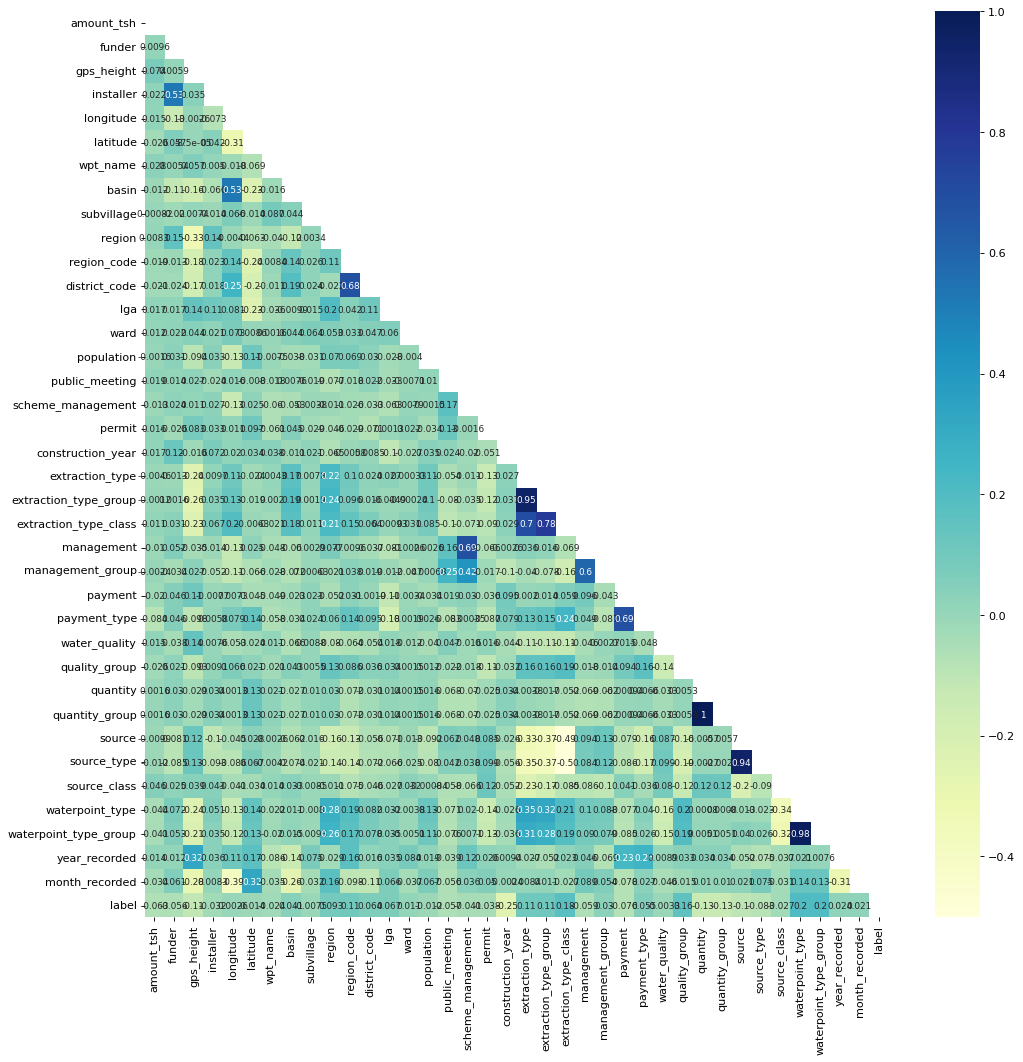

In [ ]:
temp = xTrain_si.copy()
temp['label'] = yTrain
figure(figsize=(15, 15), dpi=80)
sns.heatmap(temp.corr(), cmap="YlGnBu", annot=True, annot_kws={"size":8}, mask = np.triu(temp.corr()))

# correlation between district code and region code: this makes sense because district is part of region
# correlation between district code, region code, and long/lat: all geographic features
# correlation between scheme management and management

# TODO for linear models: drop district code because it is highly correlated with region code and longitude, but region code is more correlated with target variable y_encoded
# TODO for linear models: potentially drop year/month recorded? they are correlated with lots of other vars

# imputated data should have same correlations as pre-imputed 

#Upsampling minority classes

In [5]:
# Simple imputed data
xTrain_si = pd.read_csv('xTrain_s_mode.csv')
xTest_si = pd.read_csv('xTest_s_mode.csv')

In [ ]:
# KNN imputed data
xTrain_si = pd.read_csv('xTrain_s_knn.csv')
xTest_si = pd.read_csv('xTest_s_knn.csv')

In [6]:
yTrain = pd.read_csv('yTrain.csv')
yTest = pd.read_csv('yTest.csv')

In [7]:
xTrain_si = xTrain_si.drop(['Unnamed: 0'], 1)
xTest_si = xTest_si.drop(['Unnamed: 0'], 1)
yTrain = yTrain.drop(['Unnamed: 0'], 1)
yTest = yTest.drop(['Unnamed: 0'], 1)

<ipython-input-7-5cca5cebfbd2>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  xTrain_si = xTrain_si.drop(['Unnamed: 0'], 1)
<ipython-input-7-5cca5cebfbd2>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  xTest_si = xTest_si.drop(['Unnamed: 0'], 1)
<ipython-input-7-5cca5cebfbd2>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  yTrain = yTrain.drop(['Unnamed: 0'], 1)
<ipython-input-7-5cca5cebfbd2>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  yTest = yTest.drop(['Unnamed: 0'], 1)


In [8]:
df_train = xTrain_si.copy()
df_train['label'] = yTrain

# Get separate dataframes for each class
df_train_c0 = df_train[df_train['label'] == 0]
df_train_c1 = df_train[df_train['label'] == 1]
df_train_c2 = df_train[df_train['label'] == 2]

# Upsample minority classes so all classes have equal amounts of samples
df_train_c1_upsampled = resample(df_train_c1, random_state = 42, n_samples = 22627, replace = True)
df_train_c2_upsampled = resample(df_train_c2, random_state = 42, n_samples = 22627, replace = True)

# Combine into one dataframe
df_train_upsampled = pd.concat([df_train_c0, df_train_c1_upsampled, df_train_c2_upsampled])
df_train_upsampled['label'].value_counts()

0    22627
1    22627
2    22627
Name: label, dtype: int64

# Models + Model Evaluation & Hyperparameter Tuning

In [9]:
# Encoded, scaled, imputed, and resampled datasets
xTrain_ready = df_train_upsampled.iloc[: , :-1]
yTrain_ready = df_train_upsampled.iloc[: , -1:]
xTest_ready = xTest_si
yTest_ready = yTest

In [10]:
yTest_ready.value_counts()

label_encoded
0                9632
2                6859
1                1329
dtype: int64

In [ ]:
9632/ (9632 + 6859 + 1329) # baseline accuracy is 54% (randomly guessing the majority class every time)

0.5405162738496072

From the models that are built, try AUROC, AUPRC, F1 score as evaluation metrics. Tune the hyperparmeters with smart bounds for GridSearch

## Random Forest + XGBoost

In [ ]:
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 0)
rf_clf.fit(xTrain_ready, np.ravel(yTrain_ready))
y_pred = rf_clf.predict(xTest_ready)

NameError: ignored

In [ ]:
# Making the Confusion Matrix - need a better way to evaluate
print(pd.crosstab(yTest_ready, y_pred, rownames=['Actual Class'], colnames=['Predicted Class']))

## SVM

In [ ]:
#Import svm model
from sklearn import svm

# datasets
# Y_train = yTrain_ready.values.ravel()
Y_train = np.array(yTrain_ready).flatten()
# Y_test = yTest_ready.values.ravel()
Y_test = np.array(yTest_ready).flatten()

#Create a svm Classifier
clf = svm.SVC(kernel='linear', gamma='auto', C=2) # gamma and C - to be optimized

#Train the model using the training sets
clf.fit(xTrain_ready, Y_train) # takes forever to train --> crashes around 45min - 1hr

#Predict the response for test dataset
y_pred = clf.predict_proba(xTest_ready)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test, y_pred, multi_class='ovr'))


Label Binarization for Multi-Label AUPRC

In [12]:
# Use label_binarize to be multi-label like settings
from sklearn.preprocessing import label_binarize
y_train_binarized = label_binarize(yTrain_ready, classes=[0, 1, 2])
y_test_binarized = label_binarize(yTest_ready, classes=[0, 1, 2])

## Naive Bayes

AUPRC:  0.49375460250101383
AUC:  0.7993764094176748
F1:  0.5459799745326613


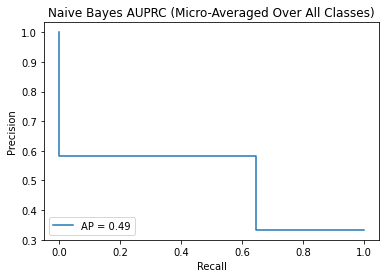

In [27]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
model = scaler.fit(xTrain_ready)
scaled_xTrain = model.transform(xTrain_ready)
model = scaler.fit(xTest_ready)
scaled_xTest = model.transform(xTest_ready)

# fitting
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
mnb = OneVsRestClassifier(MultinomialNB())
mnb.fit(scaled_xTrain, y_train_binarized)
y_score = mnb.predict(scaled_xTest)

# AUPRC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 3
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_binarized.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_binarized, y_score, average="micro")
print('AUPRC: ', average_precision_score(y_test_binarized, y_score, average="micro"))

# plot AUPRC micro-averaged
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Naive Bayes AUPRC (Micro-Averaged Over All Classes)")


from sklearn.metrics import roc_auc_score
print('AUC: ', roc_auc_score(y_test_binarized, mnb.predict_proba(scaled_xTest), multi_class='ovr'))

from sklearn.metrics import f1_score
y_hat = mnb.predict(scaled_xTest)
y_hat_binarized = label_binarize(y_hat, classes=[0, 1, 2])
print('F1: ', f1_score(y_test_binarized, y_hat_binarized, average="macro"))

## Logistic Regression

AUPRC:  0.5442682202353317
AUC:  0.8444771615494151
F1:  0.5716122186049947


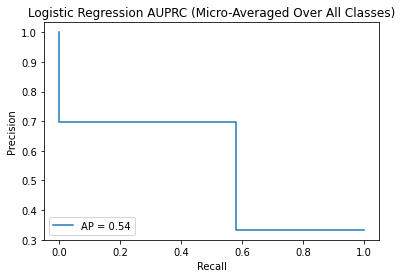

In [13]:
# fitting
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
logisticRegr = OneVsRestClassifier(LogisticRegression(max_iter = 10000))
logisticRegr.fit(xTrain_ready, y_train_binarized)
y_score = logisticRegr.predict(xTest_ready)

# AUPRC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 3
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_binarized.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_binarized, y_score, average="micro")
print('AUPRC: ', average_precision_score(y_test_binarized, y_score, average="micro"))

# plot AUPRC micro-averaged
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Logistic Regression AUPRC (Micro-Averaged Over All Classes)")


from sklearn.metrics import roc_auc_score
print('AUC: ', roc_auc_score(y_test_binarized, logisticRegr.predict_proba(xTest_ready), multi_class='ovr'))

from sklearn.metrics import f1_score
y_hat = logisticRegr.predict(xTest_ready)
y_hat_binarized = label_binarize(y_hat, classes=[0, 1, 2])
print('F1: ', f1_score(y_test_binarized, y_hat_binarized, average="macro"))

## KNN

AUPRC:  0.5955802418352403
AUC:  0.8361593061654897
F1:  0.6264886209800634


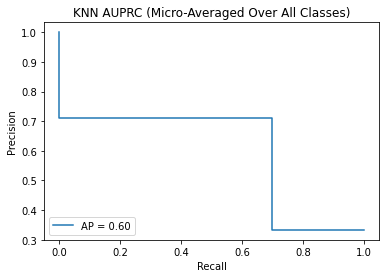

In [14]:
# fitting
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
# to be optimized
k = 7
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = k))
knn.fit(xTrain_ready, y_train_binarized)
y_score = knn.predict(xTest_ready)

# AUPRC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 3
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_binarized.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_binarized, y_score, average="micro")
print('AUPRC: ', average_precision_score(y_test_binarized, y_score, average="micro"))

# plot AUPRC micro-averaged
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("KNN AUPRC (Micro-Averaged Over All Classes)")


from sklearn.metrics import roc_auc_score
print('AUC: ', roc_auc_score(y_test_binarized, knn.predict_proba(xTest_ready), multi_class='ovr'))

from sklearn.metrics import f1_score
y_hat = knn.predict(xTest_ready)
y_hat_binarized = label_binarize(y_hat, classes=[0, 1, 2])
print('F1: ', f1_score(y_test_binarized, y_hat_binarized, average="macro"))

Grid Search by hand, using ROC AUC score:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
k_list = list(range(1, 15, 1)) # scan 1-15 neighbors in step size 1
yTrain_ready = np.array(yTrain_ready).flatten()
yTest_ready = np.array(yTest_ready).flatten()
roc_list = []
for k in k_list:
  # get a validation set and training set
  xTrain_grid, xVal_grid, yTrain_grid, yVal_grid = train_test_split(xTrain_ready,
                                                                    yTrain_ready,
                                                                    test_size = 0.3,
                                                                    random_state=334)
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(xTrain_grid, yTrain_grid)
  roc_list.append(roc_auc_score(yVal_grid, knn.predict_proba(xVal_grid), multi_class='ovr'))
max_index = roc_list.index(max(roc_list))
print('k = ',k_list[max_index])
# now train this optimal k on the train set and predict on the test set
knn = KNeighborsClassifier(n_neighbors=k_list[max_index])
knn.fit(xTrain_ready, yTrain_ready)
print(roc_auc_score(yTest_ready, knn.predict_proba(xTest_ready), multi_class='ovr'))


k =  4
0.8193790936578081


## Random Forest

Exploration using hard-coded, untuned features

AUPRC:  0.5207226447728197
AUC:  0.843936562536492
F1:  0.49126988867480437


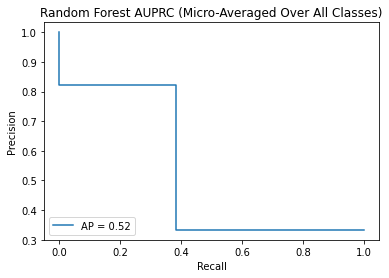

In [15]:
# random forest as first attempt - hardcoded features

# fitting
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
# initial params - to be optimized
num_trees = 100
criterion = 'gini'
mD = 10
msl = 5
max_features = 'sqrt'
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=num_trees,
                            criterion=criterion,
                            max_depth=10,
                            min_samples_leaf=msl,
                            max_features=max_features))
rf.fit(xTrain_ready, y_train_binarized)
y_score = rf.predict(xTest_ready)

# AUPRC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 3
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_binarized.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_binarized, y_score, average="micro")
print('AUPRC: ', average_precision_score(y_test_binarized, y_score, average="micro"))

# plot AUPRC micro-averaged
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Random Forest AUPRC (Micro-Averaged Over All Classes)")


from sklearn.metrics import roc_auc_score
print('AUC: ', roc_auc_score(y_test_binarized, rf.predict_proba(xTest_ready), multi_class='ovr'))

from sklearn.metrics import f1_score
y_hat = rf.predict(xTest_ready)
y_hat_binarized = label_binarize(y_hat, classes=[0, 1, 2])
print('F1: ', f1_score(y_test_binarized, y_hat_binarized, average="macro"))

Random Forest, grid search by hand, using AUROC score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
ensemble_size = list(range(1, 51, 10))
criterion = ['gini','entropy']
mD = list(range(5, 26, 10))     # note that large step sizes are necessary to
msl = list(range(1, 12, 5))     # keep runtime reasonable...
max_features = 'sqrt'
yTrain_ready = np.array(yTrain_ready).flatten()
yTest_ready = np.array(yTest_ready).flatten()
params_list = []
roc_list = []
for es in ensemble_size:
  for crit in criterion:
    for maxDepth in mD:
      for minleaf in msl:
        # get a validation set for the iteration
        xTrain_grid, xVal_grid, yTrain_grid, yVal_grid = train_test_split(xTrain_ready,
                                                                    yTrain_ready,
                                                                    test_size = 0.3,
                                                                    random_state=334)
        params_list.append({'ensemble size':es,
                            'criterion':crit,
                            'max depth':maxDepth,
                            'min-leaf samples':minleaf})
        rf = RandomForestClassifier(n_estimators=es,
                                    criterion=crit,
                                    max_depth=maxDepth,
                                    min_samples_leaf=minleaf,
                                    max_features='sqrt')
        rf.fit(xTrain_grid, yTrain_grid)
        roc_list.append(roc_auc_score(yVal_grid, 
                                      rf.predict_proba(xVal_grid), 
                                      multi_class='ovr'))

max_index = roc_list.index(max(roc_list))
print('ensemble size = ',params_list[max_index]['ensemble size'])
print('criterion = ', params_list[max_index]['criterion'])
print('max depth = ', params_list[max_index]['max depth'])
print('min-leaf samples = ', params_list[max_index]['min-leaf samples'])
print()

# train a model using these optimal hyperparameters, output ROC AUC score
rf = RandomForestClassifier(n_estimators=params_list[max_index]['ensemble size'],
                            criterion=params_list[max_index]['criterion'],
                            max_depth=params_list[max_index]['max depth'],
                            min_samples_leaf=params_list[max_index]['min-leaf samples'],
                            max_features='sqrt')
rf.fit(xTrain_ready, yTrain_ready)
print(roc_auc_score(yTest_ready, rf.predict_proba(xTest_ready), multi_class='ovr'))

ensemble size =  41
criterion =  entropy
max depth =  25
min-leaf samples =  1

0.8905856369732877


Using the tuned hyperparameters, get the relative feature importances. The Mean-decrease-in-impurity scores are shown at the top, and the permutaion-based scores are shown below that

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
ensemble_size = 41
crit = 'entropy'
maxDepth = 25
mls = 1
yTrain_ready = np.array(yTrain_ready).flatten()
yTest_ready = np.array(yTest_ready).flatten()

rf = RandomForestClassifier(n_estimators=ensemble_size,
                            max_depth=maxDepth,
                            min_samples_leaf=mls,
                            criterion=crit)
rf.fit(xTrain_ready, yTrain_ready)
roc = roc_auc_score(yTest_ready, 
                    rf.predict_proba(xTest_ready), 
                    multi_class='ovr')

# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=list(xTest_ready.columns))
sorted_importances = forest_importances.sort_values(ascending=False)
print(sorted_importances)
print()
print()

from sklearn.inspection import permutation_importance
import time
# permutation importance, see "Feature importance based on feature permutation" at
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
start_time = time.time()
result = permutation_importance(
    rf, xTest_ready, yTest_ready, n_repeats=2, random_state=42, n_jobs=10
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the permutation importances: {elapsed_time:.3f} seconds")
forest_importances = pd.Series(result.importances_mean, index=list(xTest_ready.columns))
sorted_importances_perm = forest_importances.sort_values(ascending=False)
print(sorted_importances_perm)

longitude                                    0.082219
latitude                                     0.077810
gps_height                                   0.044212
quantity_dry                                 0.035353
population                                   0.031203
                                               ...   
waterpoint_type_group_dam                    0.000009
lga_Nyamagana                                0.000007
lga_Lindi Urban                              0.000005
scheme_management_None                       0.000000
extraction_type_other - mkulima/shinyanga    0.000000
Length: 574, dtype: float64


Elapsed time to compute the permutation importances: 481.487 seconds
quantity_dry                   0.005668
latitude                       0.004630
population                     0.004237
longitude                      0.002946
quantity_group_dry             0.002497
                                 ...   
gps_height                    -0.002273
extraction_type_gravity    

# Old stuff and categorical correlation

In [ ]:
#df_dropped_na = df.dropna()
#x_cat = df_dropped_na.drop(columns = ['id', 'date_recorded',	'amount_tsh',	'gps_height',	'longitude', 'latitude', 'num_private',	'population',	'construction_year','status_group', 'label_encoded'], axis = 1)  #Independent variable - drop all missing values
x_cat = df.fillna('missing').drop(columns = ['id', 'date_recorded',	'amount_tsh',	'gps_height',	'longitude', 'latitude', 'num_private',	'population',	'construction_year','status_group', 'label_encoded'], axis = 1)  #Independent variable - treat missing as a category
x_cat = x_cat.replace(True, 'true')
x_cat = x_cat.replace(False, 'false')
x_cat.columns # don't drop region_code or district_code, because we are treating them as categorical

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [ ]:
ord_enc = OrdinalEncoder()
# don't want to re-encode region_code and district_code
x_cat[['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']] = ord_enc.fit_transform(x_cat[['funder', 'installer', 
       'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']])
x_cat

,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,1369.0,1518.0,37399.0,1.0,11807.0,3.0,11,5,51.0,1426.0,...,0.0,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0
1,469.0,545.0,37195.0,4.0,15838.0,9.0,20,2,103.0,1576.0,...,2.0,6.0,2.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0
2,825.0,2048.0,14572.0,5.0,9074.0,8.0,21,4,108.0,1624.0,...,5.0,6.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0
3,1741.0,1852.0,37285.0,7.0,8982.0,12.0,90,63,87.0,1571.0,...,2.0,6.0,2.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0
4,20.0,119.0,35529.0,4.0,7698.0,4.0,18,1,26.0,1687.0,...,2.0,6.0,2.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,436.0,201.0,513.0,5.0,5681.0,6.0,3,5,16.0,1090.0,...,5.0,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0
59396,177.0,265.0,24074.0,6.0,2980.0,3.0,11,4,91.0,353.0,...,0.0,6.0,2.0,1.0,1.0,6.0,4.0,1.0,1.0,1.0
59397,1897.0,2105.0,27926.0,6.0,8784.0,10.0,12,7,59.0,177.0,...,1.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,4.0,3.0
59398,884.0,1213.0,29693.0,6.0,14012.0,2.0,1,4,11.0,1449.0,...,2.0,6.0,2.0,2.0,2.0,7.0,5.0,0.0,4.0,3.0


In [ ]:
# chi-squared test for feature selection

#y_encoded = df_dropped_na.iloc[:,-1]   #Target variable
y_encoded = df.iloc[:,-1]   #Target variable
scores=chi2(x_cat,y_encoded)   #returns f score and p value 

p_value=pd.Series(scores[1],index=x_cat.columns)
p_value.sort_values(ascending=True)

# p-value < 0.05 means they are correlated with the target variable

funder                    0.000000e+00
extraction_type_class     0.000000e+00
waterpoint_type           0.000000e+00
extraction_type           0.000000e+00
ward                      0.000000e+00
lga                       0.000000e+00
district_code             0.000000e+00
extraction_type_group     0.000000e+00
region                    0.000000e+00
region_code               0.000000e+00
installer                 0.000000e+00
wpt_name                  0.000000e+00
waterpoint_type_group     0.000000e+00
subvillage                0.000000e+00
payment                  8.059059e-189
quantity                 7.747687e-147
quantity_group           7.747687e-147
source_type              4.078207e-124
payment_type             3.602070e-101
source                   2.323365e-100
quality_group             1.651154e-92
source_class              1.636341e-86
basin                     1.497796e-58
management                4.308947e-39
public_meeting            6.143505e-15
scheme_management        